# 임포트

In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import numpy as np

# 패션 MNIST 데이터 준비

In [2]:
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [3]:
print(train_input.shape, train_scaled.shape)

(60000, 28, 28) (48000, 28, 28, 1)


In [4]:
classes = ['티셔츠','바지','스웨터','드레스','코트','샌달','셔츠','스니커즈','가방','앵클 부츠']

# 합성곱 신경망 만들기

합성곱 층 (특징 감지) -> 밀집층 (클래스에 따른 분류 확률 계산)

## 신경망 모델 정의

In [5]:
model = keras.Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu',
                 padding='same', input_shape=(28,28,1)))
model.add(MaxPooling2D(2))
model.add(Conv2D(64, kernel_size=3, activation='relu',
                 padding='same'))
model.add(MaxPooling2D(2))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

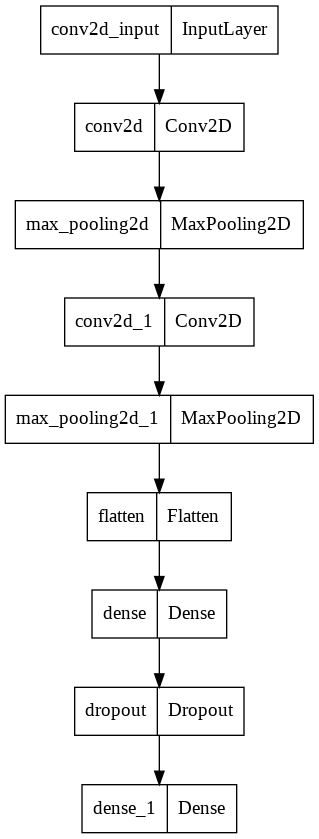

In [7]:
keras.utils.plot_model(model)

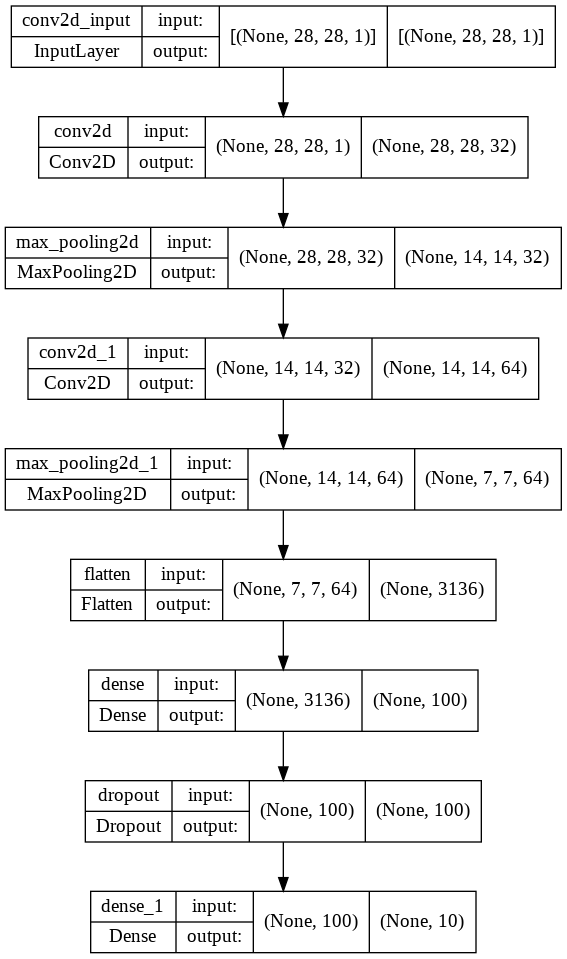

In [8]:
keras.utils.plot_model(model, show_shapes=True)

## 모델 컴파일과 훈련

In [9]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

checkpoint_cb = ModelCheckpoint('best-cnn-model.h5', save_best_only=True)
early_stopping_cb = EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 14s 6ms/step - loss: 0.5123 - accuracy: 0.8168 - val_loss: 0.3193 - val_accuracy: 0.8839
Epoch 2/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3358 - accuracy: 0.8784 - val_loss: 0.2642 - val_accuracy: 0.9000
Epoch 3/20
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2889 - accuracy: 0.8943 - val_loss: 0.2574 - val_accuracy: 0.9024
Epoch 4/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2581 - accuracy: 0.9060 - val_loss: 0.2490 - val_accuracy: 0.9068
Epoch 5/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2338 - accuracy: 0.9147 - val_loss: 0.2250 - val_accuracy: 0.9165
Epoch 6/20
1500/1500 [==============================] - 10s 6ms/step - loss: 0.2113 - accuracy: 0.9228 - val_loss: 0.2258 - val_accuracy: 0.9190
Epoch 7/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.1944 - accuracy: 0.9275 - val_loss: 0.2337 - val_accura

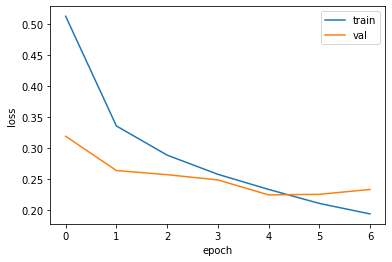

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

아홉 번째 에포크를 최적으로 생각할 수 있다. (epoch=8)

In [11]:
#세트에 대한 성능 평가
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.2250 - accuracy: 0.9165


[0.22496752440929413, 0.9164999723434448]

## 예측

새로운 데이터에 대한 예측 시행

편의상 검증 세트의 첫 번째 샘플을 새로운 데이터라 가정

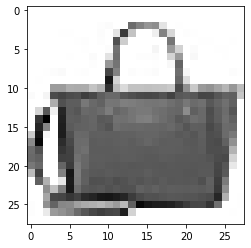

In [12]:
#첫 번째 샘플 이미지 확인
plt.imshow(val_scaled[0].reshape(28,28), cmap='gray_r')
plt.show()

In [13]:
#이 이미지에 대해 어떤 예측을 하는지 확인
preds = model.predict(val_scaled[0:1])
print(preds)

[[9.9792462e-13 1.9486635e-17 2.5478792e-14 2.0852047e-15 1.4143435e-13
  7.1842007e-14 8.5720480e-14 2.6155639e-14 1.0000000e+00 1.9241866e-14]]


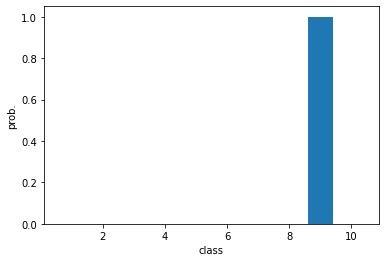

In [14]:
#막대그래프로 그려보기
plt.bar(range(1,11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [15]:
print(classes[np.argmax(preds)])

가방


In [16]:
#테스트 세트로 성능 평가
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

model.evaluate(test_scaled, test_target)

313/313 [==============================] - 2s 5ms/step - loss: 0.2481 - accuracy: 0.9106


[0.24805475771427155, 0.9106000065803528]

# 가중치 시각화

In [17]:
#체크포인트 파일 불러오기
model = keras.models.load_model('best-cnn-model.h5')

In [18]:
model.layers

In [19]:
#첫 번째 합성곱 층의 가중치
conv = model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape) #가중치 / 절편

(3, 3, 1, 32) (32,)


In [20]:
#가중치 넘파이 배열로 변환. 평균, 표준편차 계산
conv_weights = conv.weights[0].numpy()
print(conv_weights.mean(), conv_weights.std())

-0.020015376 0.21303575


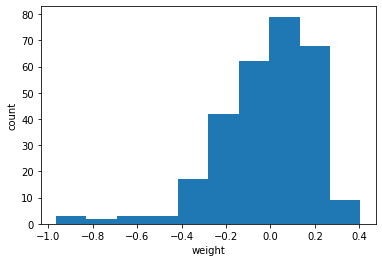

In [21]:
#가중치 히스토그램
plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

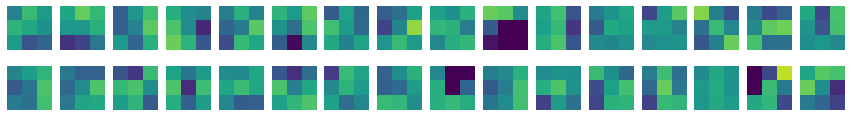

In [22]:
#32개의 커널을 16개씩 두줄로 출력
fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
  for j in range(16):
    axs[i,j].imshow(conv_weights[:,:,0,i*16+j], vmin=-0.5, vmax=0.5)
    axs[i,j].axis('off')
plt.show()

# 함수형 API

In [23]:
from tensorflow.keras import Model

input = Input((28,28,1))
x = Conv2D(32, (3,3), padding='same')(input)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(10, activation='softmax')(x)

model_fn = Model(input, output)

model_fn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0     

In [24]:
print(model_fn.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


# 특성맵 시각화

In [30]:
#함수형 API를 통해 첫 번째 층의 특성 맵을 얻을 수 있다
conv_acti = Model(model_fn.input, model_fn.layers[1].output)

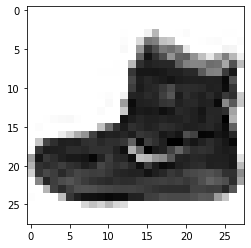

In [31]:
#훈련 세트의 첫 번째 샘플을 그려보자
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

In [32]:
#Conv2D 층이 만드는 특성 맵을 출력해보자
inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv_acti.predict(inputs)

In [33]:
print(feature_maps.shape)

(1, 28, 28, 32)


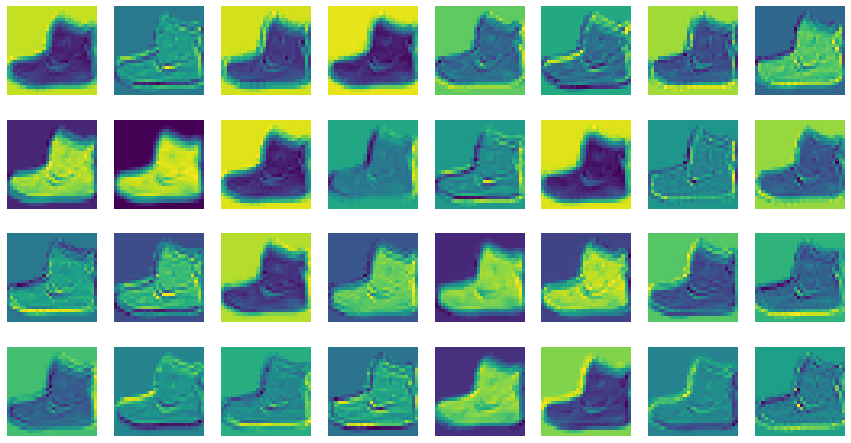

In [34]:
#특성 맵 그리기, 총 32개의 특성맵
fig, axs = plt.subplots(4, 8, figsize=(15,8))
for i in range(4):
  for j in range(8):
    axs[i,j].imshow(feature_maps[0,:,:,i*8+j])
    axs[i,j].axis('off')
plt.show()

In [35]:
#두 번째 합성곱층 특성 맵 확인
conv2_acti = Model(model_fn.input, model_fn.layers[3].output)

In [36]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv2_acti.predict(inputs)

In [37]:
print(feature_maps.shape)

(1, 14, 14, 64)


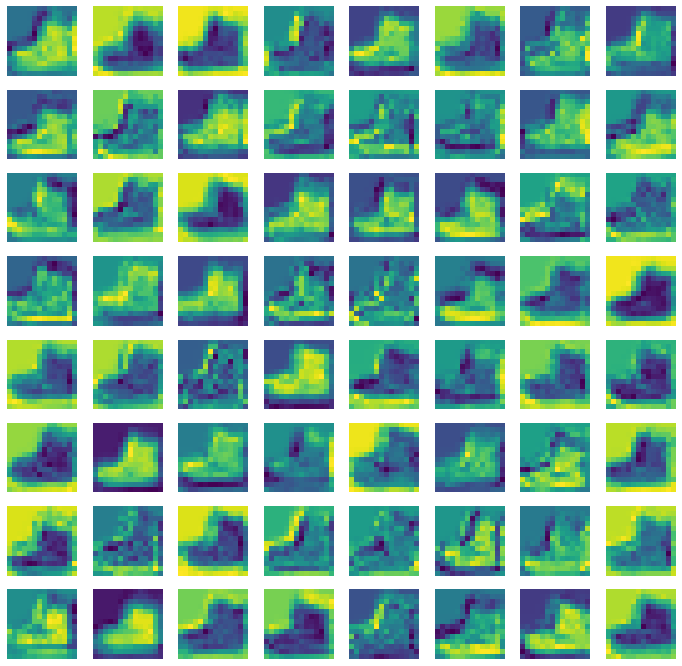

In [38]:
fig, axs = plt.subplots(8, 8, figsize=(12,12))
for i in range(8):
  for j in range(8):
    axs[i,j].imshow(feature_maps[0,:,:,i*8+j])
    axs[i,j].axis('off')
plt.show()